In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from xgboost import XGBClassifier

In [8]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

data = pd.get_dummies(data, columns=["Churn"], drop_first=True)

data = data[data["TotalCharges"] != " "]
data["TotalCharges"] = pd.to_numeric(data["TotalCharges"], errors="ignore")

train_set, test_set = train_test_split(data, test_size = 0.2, random_state=44)

data = train_set.drop(["customerID", "Churn_Yes"], axis=1)
data_labels = train_set["Churn_Yes"].copy()

data_num = data[["tenure", "MonthlyCharges", "TotalCharges"]]
data_cat = data.drop(columns=["tenure", "MonthlyCharges", "TotalCharges"])


num_attribs = list(data_num)
cat_attribs = list(data_cat)

full_pipeline = ColumnTransformer([
    ("num", Pipeline([
        ("poly", PolynomialFeatures(degree=5,
                                    include_bias=False,
                                    interaction_only=False)),
        ("scaler", StandardScaler()),
    ]), num_attribs),
    ("cat", OneHotEncoder(drop="first"), cat_attribs),
])

new_data = full_pipeline.fit_transform(data)

class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold):
        self.threshold = threshold
        print("It works!")
        
    def fit(self, X, y = None):
        
        return self
    
    def transform(self, X):

        data = pd.DataFrame(X)
        corr_matrix = data.corr(method="spearman")
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        transformed_data = np.array(data.drop(data.columns[to_drop], axis=1))
        
        return transformed_data

pipeline = Pipeline([("droper", DropTransformer(threshold = 0.90))])

data_prepared = pipeline.fit_transform(new_data)

X_train, X_val, y_train, y_val = train_test_split(data_prepared, data_labels, test_size = 0.25, random_state=44, stratify=data_labels)

It works!


#### podział zbioru treningowe na dwa zbioru, w celu dwukrotnego uczenia

In [9]:
X_train, X_train2, y_train, y_train2 = train_test_split(X_train, y_train, test_size = 0.5,
                                                        random_state=44, stratify=y_train)

#### stworzenie instancji najlepszych modeli i wyternowanie ich

In [10]:
svm_clf = SVC(C=0.1,
              class_weight='balanced',
              degree=5,
              gamma='auto',
              kernel='poly',
              probability=True,
              random_state=44
             )

xgb_clf = XGBClassifier(n_estimators = 10,
                        booster = "gblinear",
                        random_state=44,
                        scale_pos_weight = 3,
                        seed = 44
                       )

log_clf = LogisticRegression(C = 0.5,
                             solver = "liblinear",
                             class_weight = "balanced",
                             random_state = 44
                            )

rnd_clf = RandomForestClassifier(max_depth = 7,
                                 max_features = "auto",
                                 min_samples_leaf = 10,
                                 class_weight = "balanced",
                                 random_state = 44
                                )

knn_clf = KNeighborsClassifier(n_neighbors = 41,
                               leaf_size = 10,
                               p = 1,
                               metric = "euclidean",
                               weights = "uniform"
                              )

In [11]:
estimators = [svm_clf, log_clf, rnd_clf, knn_clf, xgb_clf]
for estimator in estimators:
    print("Training the: {}\n ".format(estimator))
    estimator.fit(X_train, y_train)

Training the: SVC(C=0.1, class_weight='balanced', degree=5, gamma='auto', kernel='poly',
    probability=True, random_state=44)
 
Training the: LogisticRegression(C=0.5, class_weight='balanced', random_state=44,
                   solver='liblinear')
 
Training the: RandomForestClassifier(class_weight='balanced', max_depth=7,
                       min_samples_leaf=10, random_state=44)
 
Training the: KNeighborsClassifier(leaf_size=10, metric='euclidean', n_neighbors=41, p=1)
 
Training the: XGBClassifier(base_score=None, booster='gblinear', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predict

C:\Users\nemet\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### s

In [37]:
X_val_predictions = np.empty((len(X_train2), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_train2)
    
X_val_predictions

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [96]:
params_grid = {
    "C": [0.1, 0.2, 0.25, 0.3],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "degree": [1, 2, 3, 4],
    "gamma": ["scale", "auto"],
    "probability": [True],
    "class_weight": ["balanced"]
}

gridsearch = GridSearchCV(estimator = SVC(random_state=44),
                          param_grid = params_grid,
                          scoring = "f1",
                          n_jobs = -1,
                          verbose = 1,
                          cv = 5
                         )

gridsearch.fit(X_val_predictions, y_train2)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(cv=5, estimator=SVC(random_state=44), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.25, 0.3],
                         'class_weight': ['balanced'], 'degree': [1, 2, 3, 4],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True]},
             scoring='f1', verbose=1)

In [7]:
# wczesniej:
#     SVC(C=0.25, class_weight='balanced', degree=1, kernel='sigmoid',
#     probability=True, random_state=44)

gridsearch.best_estimator_, gridsearch.best_params_

NameError: name 'gridsearch' is not defined

In [16]:
best_svc = SVC(C=0.1, class_weight='balanced', degree=3, kernel='poly', gamma="auto", probability=True, random_state=44)

best_svc.fit(X_val_predictions, y_train2)

SVC(C=0.1, class_weight='balanced', gamma='auto', kernel='poly',
    probability=True, random_state=44)

In [35]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)
    
X_val_predictions

array([[1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [24]:
y_pred = best_svc.predict(X_val_predictions)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       372

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



In [25]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

Best Threshold=0.560452, G-Mean=0.757


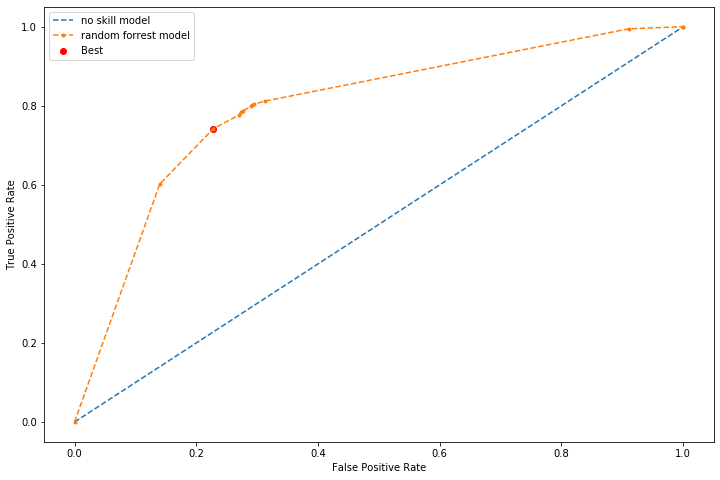

In [26]:
fpr, tpr, thresholds = roc_curve(y_val, best_svc.predict_proba(X_val_predictions)[:,1])

gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

plt.figure(figsize = (12, 8))
plt.plot([0,1], [0,1], linestyle='--', label='no skill model')
plt.plot(fpr, tpr, marker='.', linestyle='--', label='random forrest model')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [27]:
print(classification_report(y_val,
                            to_labels(best_svc.predict_proba(X_val_predictions)[:,1], thresholds[ix])))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1035
           1       0.54      0.74      0.62       372

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



In [17]:
from sklearn.metrics import plot_confusion_matrix

In [30]:
y_val.shape

(1407,)

In [31]:
X_val_predictions.shape

(1407, 5)

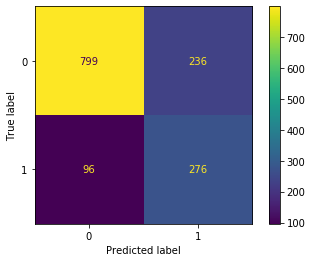

In [32]:
plot_confusion_matrix(best_svc, X_val_predictions, y_val,)

#### TP - FN + d*TN - d*FP
#### TN - 
tn - poprawnie rozpoznane zera
fn - klienci, którzy wypadli, a model ich nie rozpoznał
tn - 

In [42]:
def function(y_true, y_pred, discount = 0.2):
    
    matrix = confusion_matrix(y_true, y_pred)
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TN = matrix[1][1]
    
    return 1 - (FN + discount*FP)/(TP + discount*TN)

In [100]:
slytherin_score = make_scorer(function)

In [101]:
grid = GridSearchCV(SVC(), param_grid={'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}, scoring = slytherin_score)

In [111]:
grid.fit(X_val_predictions, y_train2)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'kernel': ('linear', 'rbf')},
             scoring=make_scorer(function))

In [113]:
grid.best_params_

{'C': 10, 'kernel': 'rbf'}

In [ ]:
{'C': 10, 'kernel': 'rbf'}

In [47]:
svc = SVC(C=0.1, kernel= "rbf")
svc.fit(X_val_predictions, y_train2)

SVC(C=0.1)

In [48]:
y_pred = svc.predict(X_val_predictions)
confusion_matrix(y_train2, y_pred)

array([[1348,  203],
       [ 247,  311]], dtype=int64)

In [46]:
function(y_train2, y_pred, discount = 0.2)

0.8047632629777525

In [49]:
function(y_train2, y_pred, discount = 0.2)

0.7960572968373281

walidacja

In [105]:
X_val_predictions = np.empty((len(X_train2), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_train2)
    
X_val_predictions

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]], dtype=float32)

In [106]:
classifier = SVC(C=0.1,
                 class_weight='balanced',
                 degree=1, kernel='sigmoid',
                 gamma="scale",
                 probability=True,
                 random_state=44
                )

scores = cross_val_score(estimator = classifier,
                         X = X_val_predictions,
                         y = y_train2,
                         scoring = "f1",
                         cv = 20,
                         n_jobs = -1,
                         verbose = 2
                        )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.4s finished


In [107]:
scores

array([0.65822785, 0.64102564, 0.6097561 , 0.61111111, 0.65753425,
       0.61764706, 0.67532468, 0.67532468, 0.62162162, 0.52777778,
       0.60273973, 0.63768116, 0.61333333, 0.57894737, 0.7027027 ,
       0.62337662, 0.6       , 0.61764706, 0.62857143, 0.62686567])

In [108]:
print(scores.mean(), scores.std())

0.6263607912782382 0.03676911142045566


In [109]:
scores.max()

0.7027027027027025